### Import Required Libraries and Set Up Environment Variables

In [6]:
!pip install fredapi

In [8]:
# Dependencies
# Clean up and delete the import that is not required
import numpy as np
import requests
import time
# from dotenv import load_dotenv
import os
import pandas as pd
import json
import os
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
# load_dotenv()

# from fredapi is a library that provides functionality to interact with the
# FRED (Federal Reserve Economic Data).
# import Fred imports the Fred class (or function) from the fredapi module.
# The fred variable can call methods defined in the Fred class to access
# economic data from the FRED API.


from fredapi import Fred

#### The US dollar (USD) to Mexican peson (MXN) foreign exchange rate.
#### Imagine you are an American going on a vacation to Mexico in three months.   
#### You can exchange your hard earned USD to MXN now or wait until you arrive
#### in Mexico. This project will help you to make an informed decision.  Better
#### yet, you can then learn to apply this methodology when you travel to other
#### foreign countries.

### Access Fred data using api_key

In [9]:
# Initializes a new object of the Fred class and assigns it to the variable
# fred.
# This api_key is used for authentication when making requests to the
# FRED (Federal Reserve Economic Data) API.
# Later need to store the api_key in .env
# FRED is a free and reliable government data source.

fred = Fred(api_key="76b3e944bbc0ad36e888dff895f8c750")


In [12]:
# Fetch data using fred.get_series().

# Use variable to store startd_date
start_date = "2010-01-01"

# Exchange rate: $1 equals Mexican pesos
exchange_rate = fred.get_series("DEXMXUS", start=start_date)

# U.S. fed rate
fed_rate = fred.get_series("FEDFUNDS", start=start_date)

# U.S. 90-days T-bill rate
t_bill_rate = fred.get_series('TB3MS', start=start_date)

# Mexico 90-days T-bill rate
mx_t_bill_rate = fred.get_series('INTGSTMXM193N', start=start_date)

# U.S. Real GDP, adjusted for inflation
us_gdp = fred.get_series('GDPC1', start=start_date)

# Mexico Real GDP, adjusted for inflation
mx_gdp = fred.get_series('NGDPRSAXDCMXQ', start=start_date)


### Create master DataFrame containing all data.

In [13]:
# Select series from https://fred.stlouisfed.org/series

# Combine data into a DataFrame.  This is the main DF.
# Each time series has different start date and availability (daily vs
# monthly).  Note: markets closed on holidays and weekends.
data = pd.DataFrame({
                    'Exchange Rate': exchange_rate,
                    'Fed Rate': fed_rate,
                    'US 90-Day T-bill': t_bill_rate,
                    'MX 90-Day T-bill': mx_t_bill_rate,
                    'US Real GDP': us_gdp,
                    'MX Real GDP': mx_gdp
                    })

In [14]:
# Using shape to get the dimension of the DataFrame.
data.shape

(8909, 6)

In [15]:
# Get the start and end date for each time series in data.
# It is important to have same start and end dates when comparing data.

exchange_rate_series = fred.get_series("DEXMXUS")
print(f"The foreign exchange rate start and end dates: {exchange_rate_series.index.min().strftime('%Y-%m-%d')} \
to {exchange_rate_series.index.max().strftime('%Y-%m-%d')}")

fed_rate_series = fred.get_series("FEDFUNDS")
print(f"The US Fed Rate start and end dates: {fed_rate_series.index.min().strftime('%Y-%m-%d')} \
to {fed_rate_series.index.max().strftime('%Y-%m-%d')}")

t_bill_rate_series = fred.get_series("DTB3")
print(f"The US 90-Day T-bill start and end dates: {t_bill_rate_series.index.min().strftime('%Y-%m-%d')} \
to {t_bill_rate_series.index.max().strftime('%Y-%m-%d')}")

exchange_rate_series = fred.get_series("TB3MS")
print(f"The Mexico 90-Day T-bill start and end dates: {exchange_rate_series.index.min().strftime('%Y-%m-%d')} \
to {exchange_rate_series.index.max().strftime('%Y-%m-%d')}")

us_gdp_series = fred.get_series("GDP")
print(f"The US GDP start and end dates: {us_gdp_series.index.min().strftime('%Y-%m-%d')} \
to {us_gdp_series.index.max().strftime('%Y-%m-%d')}")

mx_gdp_series = fred.get_series("NGDPRSAXDCMXQ")
print(f"The Mexican GDP start and end dates: {mx_gdp_series.index.min().strftime('%Y-%m-%d')} \
to {mx_gdp_series.index.max().strftime('%Y-%m-%d')}")



The foreign exchange rate start and end dates: 1993-11-08 to 2024-11-01
The US Fed Rate start and end dates: 1954-07-01 to 2024-10-01
The US 90-Day T-bill start and end dates: 1954-01-04 to 2024-11-04
The Mexico 90-Day T-bill start and end dates: 1934-01-01 to 2024-10-01
The US GDP start and end dates: 1946-01-01 to 2024-07-01
The Mexican GDP start and end dates: 1993-01-01 to 2024-04-01


In [17]:
# Preview data
# why above US GDP has value for 1946-01-01 but below no value for 1946-01-01
# Exchange Rate nad US on daily basis when market is opened.  Other data
# is based on different time interval (monthly, quarterly)
# Note: 1946-01-01 is default if start_date out of range.
data.tail(50)

,Exchange Rate,Fed Rate,US 90-Day T-bill,MX 90-Day T-bill,US Real GDP,MX Real GDP
2024-08-27,19.6486,NaN,NaN,NaN,NaN,NaN
2024-08-28,19.5288,NaN,NaN,NaN,NaN,NaN
2024-08-29,19.7880,NaN,NaN,NaN,NaN,NaN
2024-08-30,19.6576,NaN,NaN,NaN,NaN,NaN
2024-09-01,NaN,5.13,4.72,NaN,NaN,NaN
2024-09-02,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-03,19.8300,NaN,NaN,NaN,NaN,NaN
2024-09-04,19.8161,NaN,NaN,NaN,NaN,NaN
2024-09-05,19.9926,NaN,NaN,NaN,NaN,NaN
2024-09-06,20.0399,NaN,NaN,NaN,NaN,NaN


In [18]:
# Use dtpes to check data types
print(data.dtypes)
print(data.index)

Exchange Rate       float64
Fed Rate            float64
US 90-Day T-bill    float64
MX 90-Day T-bill    float64
US Real GDP         float64
MX Real GDP         float64
dtype: object
DatetimeIndex(['1934-01-01', '1934-02-01', '1934-03-01', '1934-04-01',
               '1934-05-01', '1934-06-01', '1934-07-01', '1934-08-01',
               '1934-09-01', '1934-10-01',
               ...
               '2024-10-21', '2024-10-22', '2024-10-23', '2024-10-24',
               '2024-10-25', '2024-10-28', '2024-10-29', '2024-10-30',
               '2024-10-31', '2024-11-01'],
              dtype='datetime64[ns]', length=8909, freq=None)


### Welcome.  Congratulations and latest USD to MXN foreign exchange.

### Create Foreign Exchange DataFrame from Original DataFrame

In [20]:
# Select the Date and Exchange Rate columns and store in data_fx
# Only interested in the USD to MX Peso exchange rate for now.
# Use dropna() to select dates with available Exchange Rate
# Obtain the longest time series for Exchange Rate
data_fx = data[['Exchange Rate']]
# set_index so Date prints on the x-axis when graphing.
# data_fx = data_fx.set_index('Date')
data_fx

,Exchange Rate
1934-01-01,NaN
1934-02-01,NaN
1934-03-01,NaN
1934-04-01,NaN
1934-05-01,NaN
...,...
2024-10-28,20.0444
2024-10-29,20.0000
2024-10-30,20.1720
2024-10-31,20.0314


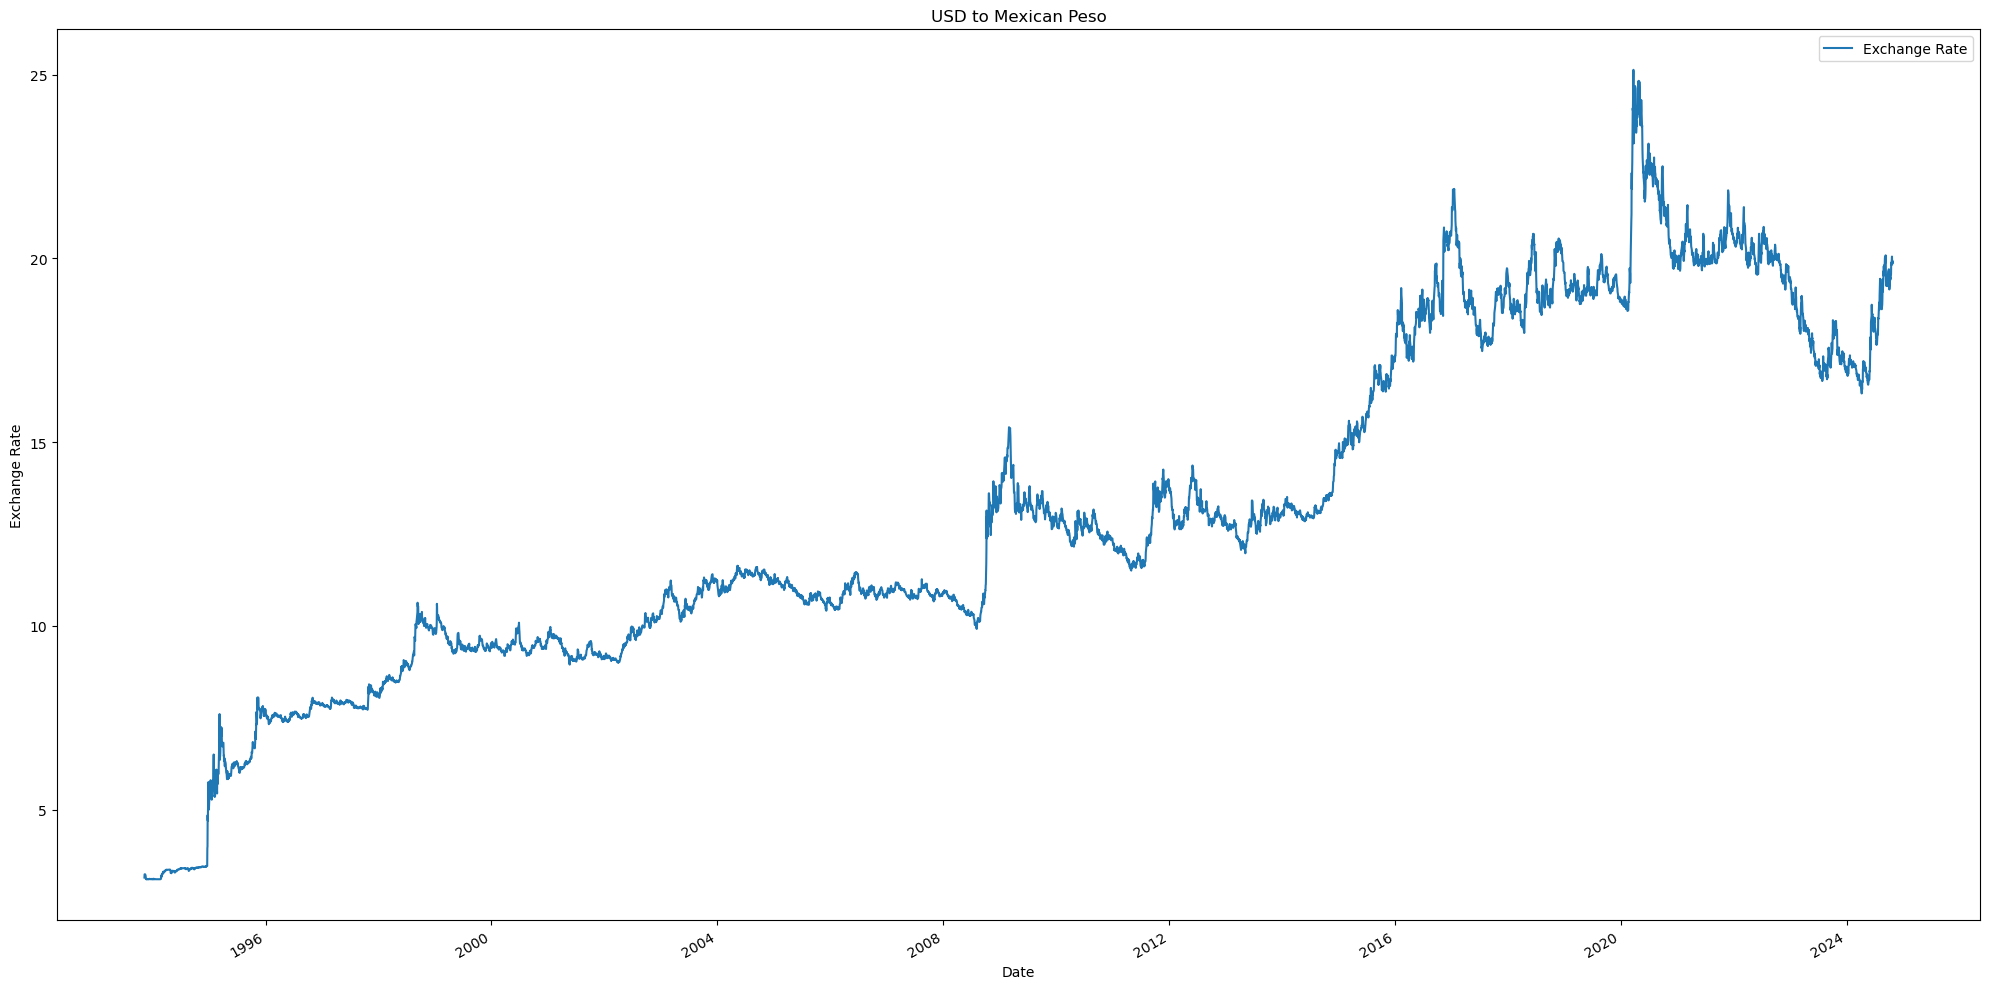

In [ ]:
# Plot the Exchange Rate.  Provide title and label x and y-axis labels.
# When the USD to Peso exchange rate increases, the USD appreciates.
# When the USD to Peso exchange rate decreases, the USD depreciates.
# Note the time short time periods when USD appreciates dramaticlly.
# There is an upward trend in USD appreciation against the MXN in the
# past 30 years.

data_fx.plot(title='USD to Mexican Peso', figsize=(20, 10))
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.tight_layout()
plt.show()

### Calculate and plot regression line.

In [ ]:
# Calculate the y = mx +b line in above graph.  Show calculation and plot the regression line.
# already performed: from scipy import stats and import matplotlib.pyplot as plt

# Perform linear regression
# Convert the index to a numerical format
x = data_fx.index.astype(np.int64)
y = data_fx["Exchange Rate"]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

In [ ]:
# Calculate the predicted y values
regression_line = slope * x + intercept

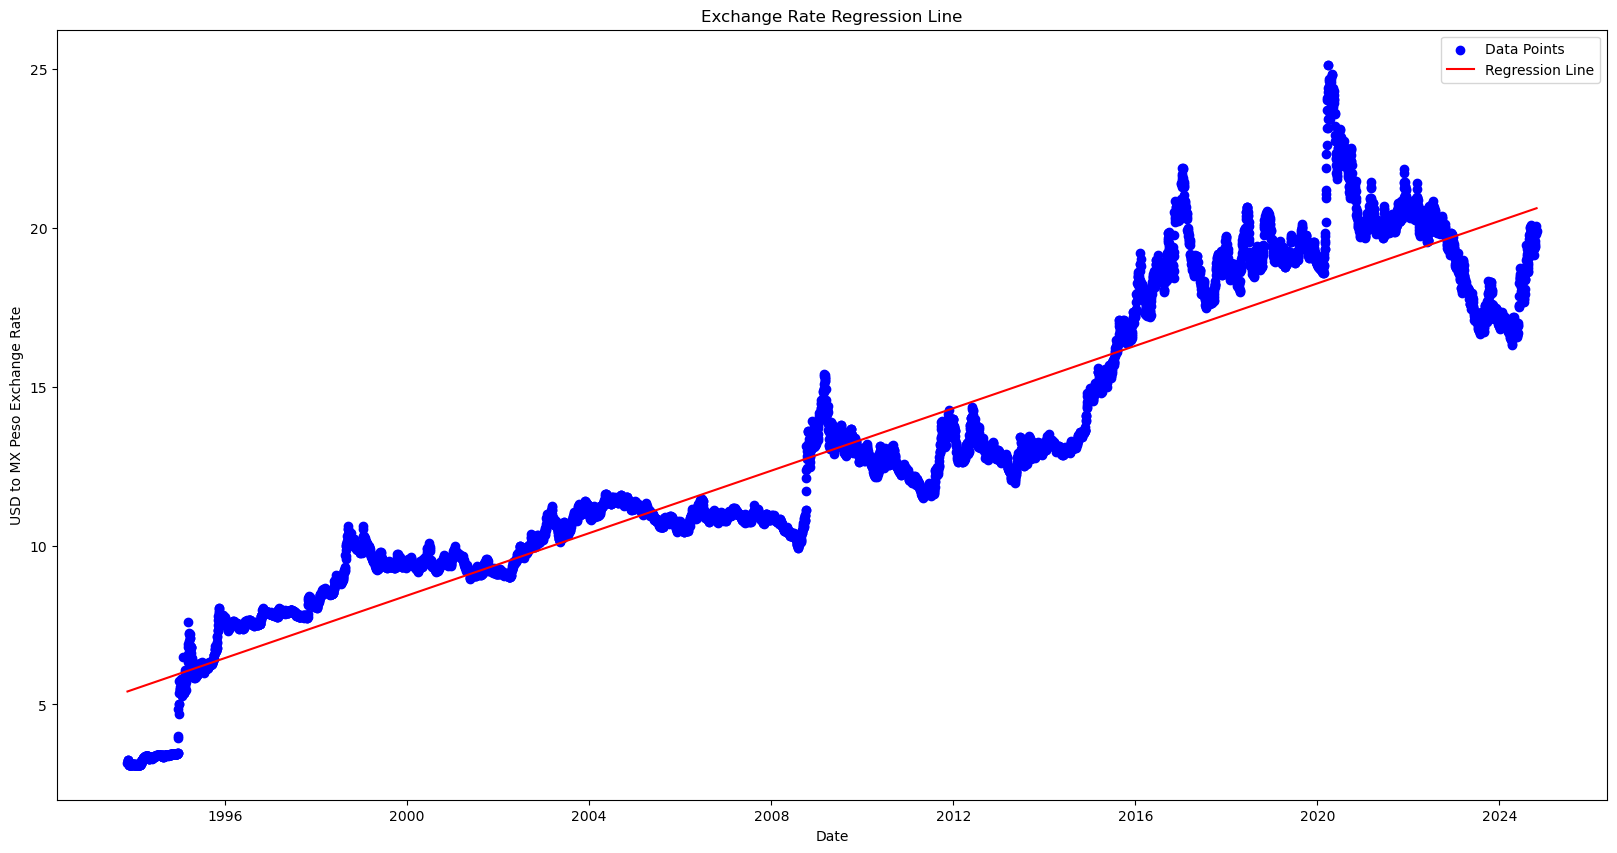

In [ ]:
# Plotting
plt.figure(figsize=(20,10))
plt.scatter(data_fx.index, y, label="Data Points", color="blue")
plt.plot(data_fx.index, regression_line, color="red", label="Regression Line")
plt.xlabel("Date")
plt.ylabel("USD to MX Peso Exchange Rate")
plt.title("Exchange Rate Regression Line")
plt.legend()
plt.show()

In [ ]:
# This simple regression line is based on everything else the same.
# Convert the last day to ordinal
x_current = data_fx.index[-1].toordinal()

In [ ]:
# Calculate the x value for 90 days later
x_90_days_later = x_current + 90

In [ ]:
print(slope)
print(intercept)

1.5564957568106976e-17
-6.308584379039237


In [ ]:
# Calaculate the predicted y value (USD to MXN foreign exchange rate)
predicted_y = slope * x_90_days_later + intercept


In [ ]:
# Cannot be negataive number
print(f"Predicted value in 90 days: {predicted_y}")

Predicted value in 90 days: -6.308584379027731


### The USD is considered a safe haven during times of economic turmoil.


In [ ]:
# for loop for each row, set start_date 756 days or 3 years back.
# if data_3_year retrieves 3 years data
# need to adjust if any data is NaN
# Create the average and +/- 2 SD (standard deviation)

for row_date in data_fx.index:
    start_date = row_date - pd.DateOffset(days=756)  # Look back 756 days
    data_3_year = data_fx.loc[start_date:row_date, 'Exchange Rate']

    # why not return False or empty for the first three years
    if not data_3_year.empty:
        avg = data_3_year.mean()
        std = data_3_year.std()

        # Assign the computed values using loc
        data_fx.loc[row_date, '1_year_avg'] = avg
        data_fx.loc[row_date, '2_std_upper'] = avg + 2 * std
        data_fx.loc[row_date, '2_std_lower'] = avg - 2 * std


C:\Users\Carl\AppData\Local\Temp\ipykernel_1340\3542955160.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


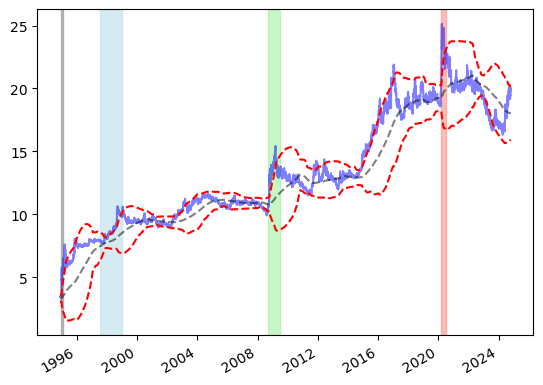

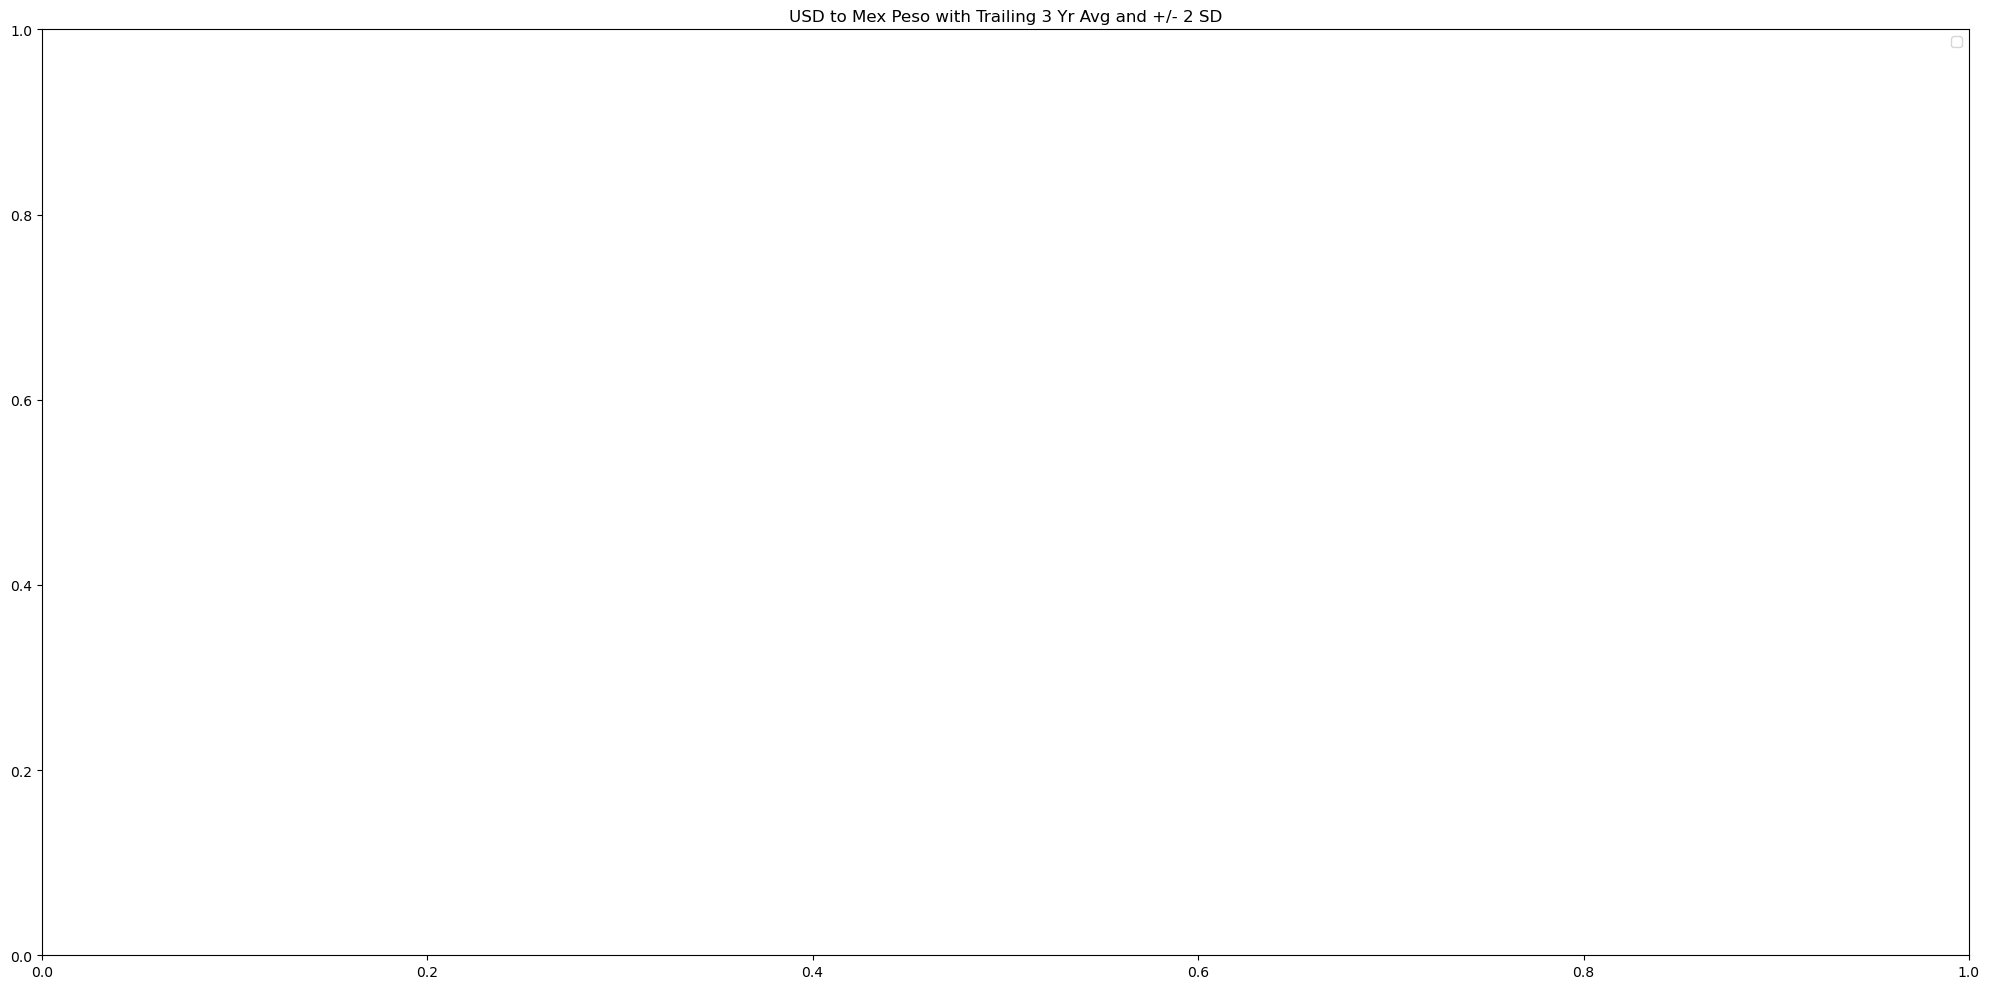

In [ ]:
# For 3 year trailing average, forward 3 years or 756 days
filtered_data = data_fx[data_fx.index >= data_fx.index[251]]

# Plotting: calculate current, 3 year moving average, and +/- 2 SD
filtered_data['Exchange Rate'].plot(label='Exchange Rate', color='blue', alpha=0.5)
filtered_data['1_year_avg'].plot(label='3 Year Avg', color='black', linestyle="--", alpha=0.5)
filtered_data['2_std_upper'].plot(label='2 Std Upper', color='red', linestyle='--')
filtered_data['2_std_lower'].plot(label='2 Std Lower', color='red', linestyle='--')

# Major economic events effecting USD to MXN exchanage rate
plt.axvspan(pd.Timestamp('1994-12-01'), pd.Timestamp('1995-01-31'), color='grey', alpha=0.5, label='Tequila Crisis')
plt.axvspan(pd.Timestamp('1997-07-01'), pd.Timestamp('1998-12-31'), color='lightblue', alpha=0.5, label='Asian Financial Crisis')
plt.axvspan(pd.Timestamp('2008-09-01'), pd.Timestamp('2009-06-30'), color='lightgreen', alpha=0.5, label='Global Financial Crisis')
plt.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2020-06-30'), color='salmon', alpha=0.5, label='COVID-19 Pandemic')

 # Label and plot
plt.figure(figsize=(20, 10))
plt.title('USD to Mex Peso with Trailing 3 Yr Avg and +/- 2 SD')
plt.legend()
plt.tight_layout()
plt.show()

# If all the code in one panel or cell, it works.
# How to fix this problem


### Correlation

In [ ]:

data

,Exchange Rate,Fed Rate,US 90-Day T-bill,MX 90-Day T-bill,US GDP,MX GDP
1934-01-01,NaN,NaN,0.72,NaN,NaN,NaN
1934-02-01,NaN,NaN,0.62,NaN,NaN,NaN
1934-03-01,NaN,NaN,0.24,NaN,NaN,NaN
1934-04-01,NaN,NaN,0.15,NaN,NaN,NaN
1934-05-01,NaN,NaN,0.16,NaN,NaN,NaN
...,...,...,...,...,...,...
2024-10-21,20.0494,NaN,NaN,NaN,NaN,NaN
2024-10-22,19.8992,NaN,NaN,NaN,NaN,NaN
2024-10-23,19.9284,NaN,NaN,NaN,NaN,NaN
2024-10-24,19.8520,NaN,NaN,NaN,NaN,NaN


In [ ]:
quarterly_avg = data.resample('Q').mean()
quarterly_avg

C:\Users\Carl\AppData\Local\Temp\ipykernel_1340\298446898.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_avg = data.resample('Q').mean()


,Exchange Rate,Fed Rate,US 90-Day T-bill,MX 90-Day T-bill,US GDP,MX GDP
1934-03-31,NaN,NaN,0.526667,NaN,NaN,NaN
1934-06-30,NaN,NaN,0.153333,NaN,NaN,NaN
1934-09-30,NaN,NaN,0.183333,NaN,NaN,NaN
1934-12-31,NaN,NaN,0.250000,NaN,NaN,NaN
1935-03-31,NaN,NaN,0.180000,NaN,NaN,NaN
...,...,...,...,...,...,...
2023-12-31,17.545556,5.330000,5.283333,11.060000,22960.600,6300104.5
2024-03-31,16.983616,5.330000,5.233333,11.120000,23053.545,6306870.5
2024-06-30,17.222032,5.330000,5.243333,10.976667,23223.906,6316702.0
2024-09-30,18.924516,5.263333,4.990000,10.840000,23386.248,NaN


In [ ]:
quarterly_avg.dropna(inplace=True)
quarterly_avg

,Exchange Rate,Fed Rate,US 90-Day T-bill,MX 90-Day T-bill,US GDP,MX GDP
1993-12-31,3.123720,2.990000,3.060000,13.096667,10833.987,3513104.5
1994-03-31,3.182411,3.213333,3.243333,9.900000,10939.116,3548062.0
1994-06-30,3.345166,3.940000,3.986667,16.110000,11087.361,3628977.5
1994-09-30,3.395023,4.486667,4.476667,15.096667,11152.176,3649230.5
1994-12-31,3.618785,5.166667,5.280000,15.283333,11279.932,3688503.5
...,...,...,...,...,...,...
2023-06-30,17.689335,4.990000,5.073333,11.256667,22539.418,6257248.0
2023-09-30,17.054851,5.260000,5.290000,11.153333,22780.933,6303922.5
2023-12-31,17.545556,5.330000,5.283333,11.060000,22960.600,6300104.5
2024-03-31,16.983616,5.330000,5.233333,11.120000,23053.545,6306870.5


In [ ]:
correlation_matrix = quarterly_avg.corr()
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print(correlation_matrix)

                  Exchange Rate  Fed Rate  US 90-Day T-bill  MX 90-Day T-bill    US GDP    MX GDP
Exchange Rate          1.000000 -0.529343         -0.506422         -0.508896  0.929682  0.898167
Fed Rate              -0.529343  1.000000          0.994867          0.691894 -0.474324 -0.508572
US 90-Day T-bill      -0.506422  0.994867          1.000000          0.686479 -0.448420 -0.488908
MX 90-Day T-bill      -0.508896  0.691894          0.686479          1.000000 -0.593637 -0.653261
US GDP                 0.929682 -0.474324         -0.448420         -0.593637  1.000000  0.976914
MX GDP                 0.898167 -0.508572         -0.488908         -0.653261  0.976914  1.000000


### Interest Rate Parity (IRP). F = S x (1 + i US)/(1 + i MX).  
##### F is forward exchange rate, S is spot exchange rate (current), i US
##### is US 90 day T-bill and i MX is Mexico 90 day T-bill.
##### Example: F = 18 x (1.02) / (1.05) = 17.78
##### Everything else the same, the USD will depreciate vs MXN.

In [ ]:
# Calculate the forward exchange rate out 90 days and compare to actual
# exchange rate.

In [ ]:
# Run a correlation to see if IRP is a good predictor of future exchange rate.

### Prophet